In [8]:
import matplotlib.pyplot as plt
import json
import numpy as np
import os
import tensorflow as tf
import tensorflow.keras.layers as tfl

from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers import RandomFlip, RandomRotation

In [10]:
BATCH_SIZE = 32
IMG_SIZE = (160, 160)
directory = "datasets/Alpaca/"
train_dataset = image_dataset_from_directory(directory,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             validation_split=0.2,
                                             subset='training',
                                             seed=42)
validation_dataset = image_dataset_from_directory(directory,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             validation_split=0.2,
                                             subset='validation',
                                             seed=42)

Found 327 files belonging to 2 classes.
Using 262 files for training.


I0000 00:00:1752733640.468475   22091 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5563 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


Found 327 files belonging to 2 classes.
Using 65 files for validation.


2025-07-17 11:27:25.283847: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


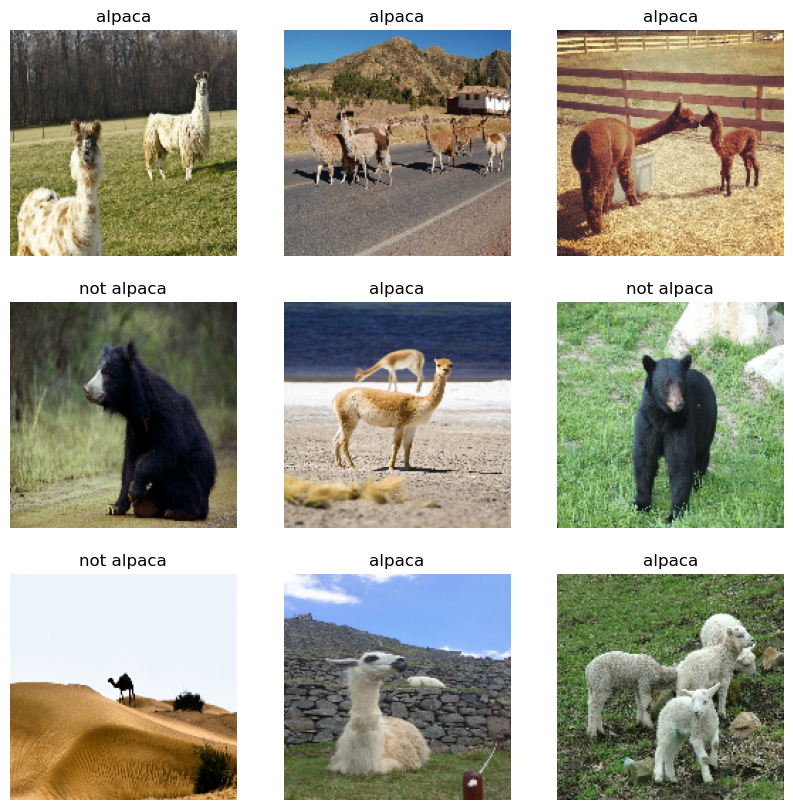

In [11]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [12]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)

### Data Augmentation

In [25]:
def data_augmenter():
    data_augmentation = tf.keras.Sequential()
    data_augmentation.add(RandomFlip('horizontal'))
    data_augmentation.add(RandomRotation(0.2))

    return data_augmentation

2025-07-17 11:36:21.813745: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


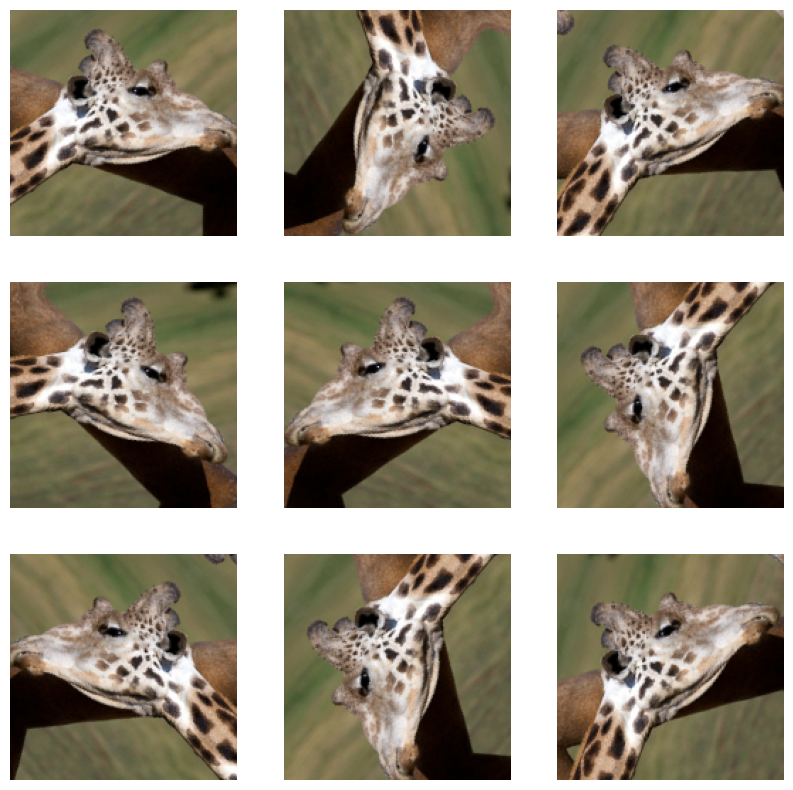

In [28]:
data_augmentation = data_augmenter()

for image, _ in train_dataset.take(1):
    plt.figure(figsize=(10, 10))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')

In [29]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

### ImageNet mobile V2

In [30]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model_path="models/imagenet_base_model/with_top_mobilenet_v2_weights_tf_dim_ordering_tf_kernels_1.0_160.h5"

base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=True,
                                               weights=base_model_path)

In [32]:
base_model.summary()

Model: "mobilenetv2_1.00_160"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 160, 160,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 80, 80,    │        864 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 80, 80,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 80, 80,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 80, 80,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 80, 80,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 80, 80,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 80, 80,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 80, 80,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 81, 81,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 40, 40,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 40, 40,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 40, 40,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 40, 40,    │      2,304 │ block_1_depthwis

 Total params: 3,538,984 (13.50 MB)

 Trainable params: 3,504,872 (13.37 MB)

 Non-trainable params: 34,112 (133.25 KB)

In [34]:
total_layers = len(base_model.layers)
print(base_model.layers[total_layers - 2].name)
print(base_model.layers[total_layers - 1].name)

global_average_pooling2d
predictions


In [35]:
x_batch, y_batch = next(iter(train_dataset))
pred_batch = base_model(x_batch)

I0000 00:00:1752734524.629864   22091 cuda_dnn.cc:529] Loaded cuDNN version 90701


In [45]:
# Model output Batch of 32, with 1000 labels
print(pred_batch.shape)

(32, 1000)


In [44]:
# Actual data Batch of 32, with binary labels
y_batch

<tf.Tensor: shape=(32,), dtype=int32, numpy=
array([1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0,
       0, 0, 1, 0, 1, 1, 1, 1, 0, 0], dtype=int32)>

In [40]:
base_model.trainable=False

In [41]:
image_variable = tf.Variable(preprocess_input(x_batch))
pred = base_model(image_variable)

### Adding Top/Last Layers

In [53]:
def alpaca_model(image_shape=(160,160), data_augmentation=data_augmenter()):
    input_shape = image_shape + (3,)

    base_model_path = 'models/imagenet_base_model/without_top_mobilenet_v2_weights_tf_dim_ordering_tf_kernels_1.0_160_no_top.h5'

    base_model = tf.keras.applications.MobileNetV2(input_shape=input_shape, include_top=False, weights=base_model_path)

    base_model.trainable = False

    inputs = tf.keras.Input(shape=input_shape)

    x = data_augmentation(inputs)
    x = preprocess_input(x)
    x = base_model(x, training=False)

    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dropout(0.2)(x)

    outputs = tf.keras.layers.Dense(1)(x)

    model = tf.keras.Model(inputs=inputs , outputs=outputs)

    return model
    

In [54]:
model2 = alpaca_model(IMG_SIZE, data_augmentation)

In [58]:
base_learning_rate = 0.001
model2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [59]:
initial_epochs = 5
history = model2.fit(train_dataset, validation_data=validation_dataset, epochs=initial_epochs)

Epoch 1/5
9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 156ms/step - accuracy: 0.5510 - loss: 0.7579 - val_accuracy: 0.6000 - val_loss: 0.5918
Epoch 2/5
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.6364 - loss: 0.5893 - val_accuracy: 0.7231 - val_loss: 0.4824
Epoch 3/5
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.6772 - loss: 0.5322 - val_accuracy: 0.7846 - val_loss: 0.3890
Epoch 4/5
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.7584 - loss: 0.4834 - val_accuracy: 0.7846 - val_loss: 0.3553
Epoch 5/5
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.7963 - loss: 0.4615 - val_accuracy: 0.8308 - val_loss: 0.3163


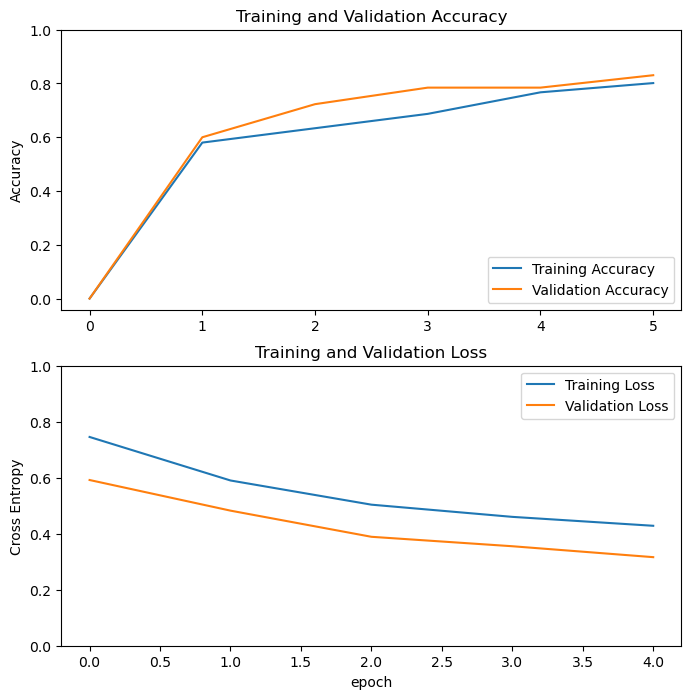

In [60]:
acc = [0.] + history.history['accuracy']
val_acc = [0.] + history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [61]:
class_names

['alpaca', 'not alpaca']

### Fine Tuning

In [66]:
base_model = None
for layer in model2.layers:
    if "mobilenetv2" in layer.name:
        base_model = layer
        break

if base_model is not None:
    base_model.trainable = True
    print(f"Total number of layers in the model: {len(base_model.layers)}")
else:
    print("Base model not found.")


Total number of layers in the model: 154


In [79]:
base_model = model2.layers[-4]
base_model.trainable = True

print(f"Total number of layers in the model: {len(base_model.layers)}")

fine_tune_from_layer = 120

for layer in base_model.layers[:fine_tune_from_layer]:
    layer.trainable = False

loss_function = tf.keras.losses.BinaryCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.1*base_learning_rate)
metrics = ['accuracy']

model2.compile(loss=loss_function, optimizer=optimizer, metrics=metrics)

Total number of layers in the model: 154


In [81]:
fine_tune_epochs = 5
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model2.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 12s 380ms/step - accuracy: 0.7485 - loss: 0.5501 - val_accuracy: 0.9077 - val_loss: 0.2240
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step - accuracy: 0.8850 - loss: 0.3150 - val_accuracy: 0.9538 - val_loss: 0.1792
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - accuracy: 0.9558 - loss: 0.1816 - val_accuracy: 0.9538 - val_loss: 0.1439
Epoch 8/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - accuracy: 0.9543 - loss: 0.1522 - val_accuracy: 0.9538 - val_loss: 0.1232
Epoch 9/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - accuracy: 0.9515 - loss: 0.1384 - val_accuracy: 0.9692 - val_loss: 0.1034
Epoch 10/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - accuracy: 0.9468 - loss: 0.1258 - val_accuracy: 0.9692 - val_loss: 0.0926


In [82]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

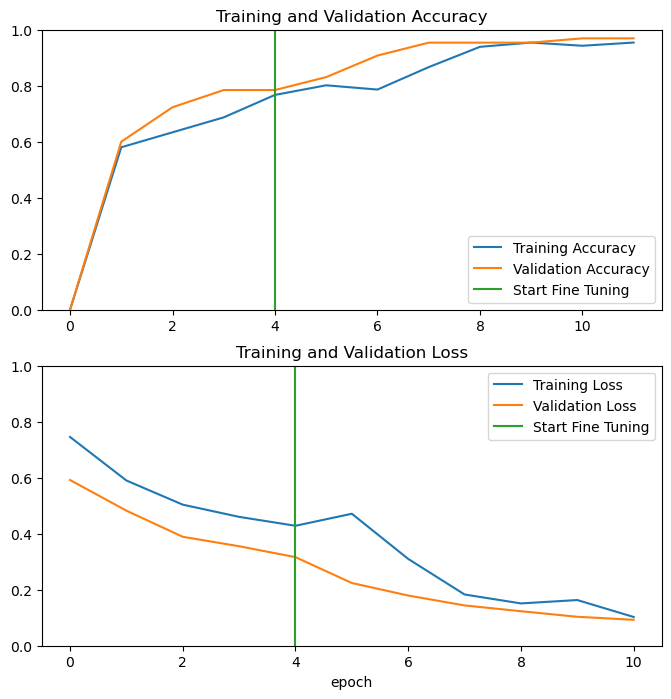

In [83]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()